#### Imports

In [19]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import itertools

#### Algorithms

In [20]:
class LinearRegressionRidge:
    def __init__(self, alpha=7):
        self.alpha = alpha
        self.w = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        I = np.identity(n_features)
        self.w = np.linalg.solve(
            X.T @ X + self.alpha * I, X.T @ y
        )

    def predict(self, X):
        return np.sign(X @ self.w)

In [21]:
class LinearClassifier:
    def __init__(self, loss="lr", alpha=0.5, beta=0, max_iter=100, learning_rate=0.1):
        self.loss = loss
        self.alpha = alpha
        self.beta = beta
        self.max_iter = max_iter
        self.learning_rate = learning_rate
        self.w = None

    def __loss(self, M):
        if self.loss == "svm":
            return np.where(M < 1, 1 - M, 0)
        elif self.loss == "lda":
            return (1 - M) ** 2
        elif self.loss == "lr":
            return np.log2(1 + np.exp(-M))
        elif self.loss == "adaboost":
            return np.exp(-M)

    def __loss_grad(self, X, y, M):
        if self.loss == "svm":
            grad_loss = np.where(M < 1, -y * X, 0)
        elif self.loss == "lda":
            grad_loss = -2 * (1 - M) * y * X
        elif self.loss == "lr":
            exp_m = np.exp(-M)
            grad_loss = - exp_m / ((1 + exp_m) * np.log(2)) * y * X
        elif self.loss == "adaboost":
            grad_loss = -np.exp(-M) * y * X
        else:
            raise ValueError("Неизвестная функция потерь.")
        return grad_loss

    def __regularization_grad(self):
        return self.alpha * np.sign(self.w) + 2 * self.beta * self.w

    def __regularization_elastic_net(self):
        return self.alpha * np.sum(np.abs(self.w)) + self.beta * np.sum(self.w ** 2)

    def __risk(self, X, y):
        M = y * np.dot(X, self.w)
        loss = self.__loss(M)
        total_loss = np.sum(loss)
        return total_loss + self.__regularization_elastic_net()

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)
        for _ in range(self.max_iter):
            curr_grad_weights = np.zeros(n_features)
            for i in range(n_samples):
                M = y[i] * (X[i] @ self.w)
                grad_loss = self.__loss_grad(X[i], y[i], M)
                curr_grad_weights += grad_loss
            self.w -= self.learning_rate * (curr_grad_weights + self.__regularization_grad())
        return self.__risk(X, y)

    def predict(self, X):
        return np.sign(X @ self.w)

In [22]:
class SupportVectorMachine:
    def __init__(self, kernel="non-homo-polynomial", C=5, kernel_param=1, max_iter=100, learning_rate=0.01):
        self.kernel_name = kernel
        self.C = C
        self.kernel_param = kernel_param
        self.max_iter = max_iter
        self.learning_rate = learning_rate
        self.alpha = None
        self.__kernel_matrix = None
        self.x_train = None
        self.y_train = None

    def __kernel_function(self, X1, X2):
        if self.kernel_name == "linear":
            return np.dot(X1, X2.T)
        elif self.kernel_name == "non-homo-polynomial":
            return (np.dot(X1, X2.T) + 1) ** self.kernel_param
        elif self.kernel_name == "rbf":
            gamma = self.kernel_param
            diff = X1[:, None] - X2[None, :]
            return np.exp(-np.linalg.norm(diff, axis=2) ** 2 / (2 * gamma ** 2))
        else:
            raise ValueError("Неизвестное ядро.")

    def __calc_kernel_matrix(self, X):
        n_samples = X.shape[0]
        self.__kernel_matrix = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                self.__kernel_matrix[i, j] = self.__kernel_function(X[i:i + 1], X[j:j + 1])[0, 0]

    def __alpha_grad(self, i):
        y_i = self.y_train[i]
        decision = sum(
            self.alpha[j] * self.y_train[j] * self.__kernel_matrix[j, i]
            for j in range(len(self.alpha))
        ) + self.b
        return y_i * decision - 1

    def __empirical_risk(self):
        risk = 0
        n_samples = self.x_train.shape[0]
        for i in range(n_samples):
            for j in range(n_samples):
                risk += (
                        self.alpha[i]
                        * self.alpha[j]
                        * self.y_train[i]
                        * self.y_train[j]
                        * self.__kernel_matrix[i, j]
                )
        return np.sum(self.alpha) - 0.5 * risk

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.alpha = np.zeros(n_samples)
        self.b = 0
        self.x_train = X
        self.y_train = y

        self.__calc_kernel_matrix(X)

        for _ in range(self.max_iter):
            for i in range(n_samples):
                grad = self.__alpha_grad(i)
                self.alpha[i] -= self.learning_rate * grad
                self.alpha[i] = np.clip(self.alpha[i], 0, self.C)

        return self.__empirical_risk()

    def predict(self, X_test):
        n_samples = X_test.shape[0]
        decision = np.zeros(n_samples)
        for i in range(n_samples):
            for j in range(len(self.alpha)):
                decision[i] += (
                        self.alpha[j]
                        * self.y_train[j]
                        * self.__kernel_function(X_test[i:i + 1], self.x_train[j:j + 1])[0, 0]
                )
            decision[i] += self.b
        return np.sign(decision)


In [23]:
phones = pd.read_csv('expensive_dataset.csv')
phones.columns.tolist()
phones.drop(columns=['model', 'release_date', 'main_camera'], inplace=True)
phones.drop(phones.columns[0], axis=1, inplace=True)
X = phones.drop(columns='expensive')
y = phones['expensive']


def get_splitted_data(train_size):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=42)
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()
    y_train = np.where(y_train == 0, -1, 1)
    y_test = np.where(y_test == 0, -1, 1)
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = get_splitted_data(0.75)

### Best hyperparams

In [24]:
def search_best_params(classifier, params, filter=lambda _: False):
    best_score = 0
    best_params = None

    keys, values = zip(*params.items())
    param_combinations = list(itertools.product(*values))

    for combination in tqdm(param_combinations, desc="Grid Search Progress"):
        params = dict(zip(keys, combination))

        if filter(params):
            continue

        algo = classifier(**params)
        algo.fit(X_train, y_train)

        y_pred = algo.predict(X_test)
        try:
            score = accuracy_score(y_test, y_pred)
        except ValueError:
            print(f"Error with params {combination}")
            score = 0

        if score > best_score:
            best_score = score
            best_params = params
    return best_params, best_score

### Linear Regression

In [25]:
lr_param_grid = {'alpha': [0.1]}
# search_best_params(LinearRegressionRidge, lr_param_grid)

best_lr_params = {'alpha': 7}
best_lr_accuracy = 0.9838709677419355
print(f"Лучшие параметры: {best_lr_params}")
print(f"Лучшая точность: {best_lr_accuracy:.4f}")

Лучшие параметры: {'alpha': 7}
Лучшая точность: 0.9839


## Linear Classifier

In [26]:
lc_param_grid = {
    'learning_rate': [0.1, 0.05, 0.01, 0.0005, 0.0001],
    'loss': ['svm', 'lda', 'lr', 'adaboost'],
    'alpha': [0, 0.5, 1, 10, 100],
    'beta': [0, 0.5, 1, 10, 100],
}

# search_best_params(LinearClassifier, lc_param_grid)
best_lc_params = {'learning_rate': 0.1, 'loss': 'lr', 'alpha': 0.5, 'beta': 0}
best_lc_accuracy = 0.9838709677419355
print(f"Лучшие параметры: {best_lc_params}")
print(f"Лучшая точность: {best_lc_accuracy:.4f}")

Лучшие параметры: {'learning_rate': 0.1, 'loss': 'lr', 'alpha': 0.5, 'beta': 0}
Лучшая точность: 0.9839


In [27]:
svm_param_grid = {
    'learning_rate': [0.1, 0.05, 0.01, 0.0005, 0.0001],
    'kernel': ['linear', 'non-homo-polynomial', 'rbf'],
    'C': [0, 0.5, 1, 5, 10],
    'kernel_param': [1, 2, 3, 4, 5],
}


def svm_filter(params):
    if params['kernel'] == 'linear' and params['kernel_param'] != 1:
        return True
    return False


# search_best_params(SupportVectorMachine, svm_param_grid, svm_filter)
best_lc_params = {'learning_rate': 0.1,
                  'kernel': 'non-homo-polynomial',
                  'C': 5,
                  'kernel_param': 1}
best_lc_accuracy = 0.9919354838709677
print(f"Лучшие параметры: {best_lc_params}")
print(f"Лучшая точность: {best_lc_accuracy:.4f}")

Лучшие параметры: {'learning_rate': 0.1, 'kernel': 'non-homo-polynomial', 'C': 5, 'kernel_param': 1}
Лучшая точность: 0.9919


### Learning curve with empirical risk

In [28]:
def plot_curve(model, X, y, n=10):
    percents = np.linspace(0, 1, n)
    volumes = [int(x) for x in percents * len(X)]
    emp_risks = []
    for train_volume in volumes:
        curr_X, curr_y = X[:train_volume], y[:train_volume]
        emp_risks.append(model.fit(curr_X, curr_y))

    plt.figure(figsize=(10, 6))
    plt.plot(percents, emp_risks, label="Empirical Risk", marker='o')
    plt.title("Learning Curve: Empirical Risk vs Training Set Size")
    plt.xlabel("Training Set Size")
    plt.ylabel("Empirical Risk")
    plt.grid(True)
    plt.legend()
    plt.show()

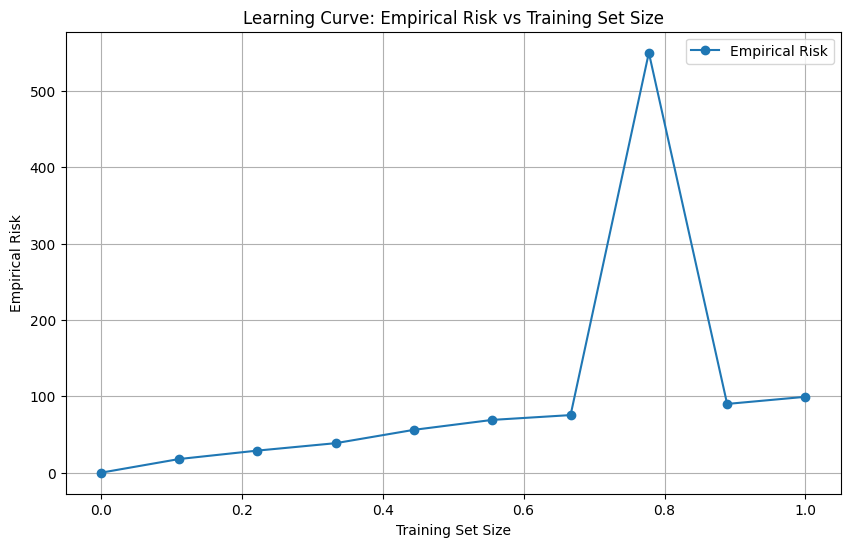

In [29]:
plot_curve(LinearClassifier(), X_train, y_train)

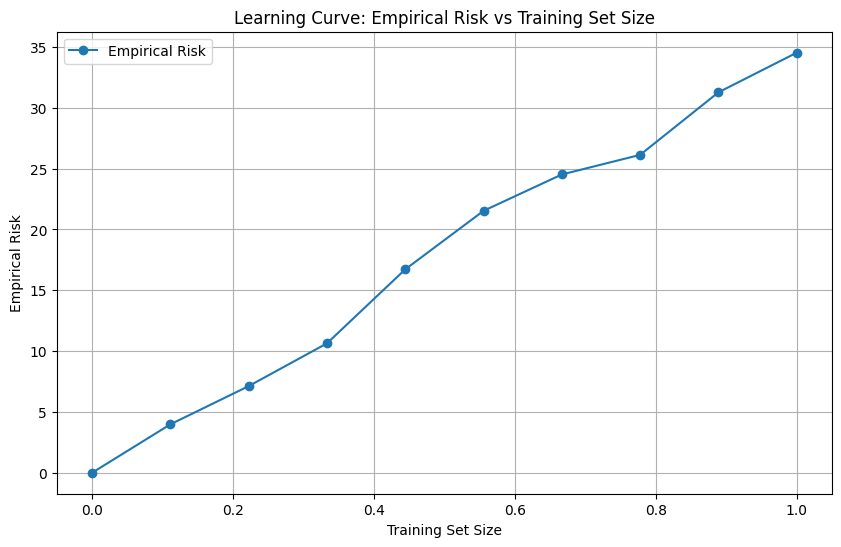

In [30]:
plot_curve(SupportVectorMachine(), X_train, y_train)

### Learning curve for objective function

In [31]:
def plot_curve_for_obj_fun(model, X, y, X_test, y_test, n=10):
    percents = np.linspace(0.1, 1, n)
    volumes = [int(x) for x in percents * len(X)]
    obj_fun_values = []
    conf_intervals = []
    for train_volume in volumes:
        curr_X, curr_y = X[:train_volume], y[:train_volume]
        model.fit(curr_X, curr_y)
        y_predict = model.predict(X_test)
        obj_fun_values.append(accuracy_score(y_test, y_predict))

        std_err = np.std(y_predict - y_test) / np.sqrt(len(curr_X))
        conf_intervals.append(1.96 * std_err)

    obj_fun_values = np.array(obj_fun_values)
    conf_intervals = np.array(conf_intervals)

    lrr = LinearRegressionRidge()
    lrr.fit(X_train, y_train)
    lrr_value = accuracy_score(y_test, lrr.predict(X_test))

    plt.figure(figsize=(10, 6))
    plt.plot(percents, obj_fun_values, label="Objective function", marker='o')
    plt.axhline(y=lrr_value,
                color='red',
                linestyle='--',
                label=f"Linear Regression y = {lrr_value:.2f}"
                )
    plt.fill_between(percents,
                     obj_fun_values - conf_intervals,
                     obj_fun_values + conf_intervals,
                     color='blue',
                     alpha=0.2,
                     label='95% confidence interval'
                     )
    plt.title("Learning Curve: Objective function vs Training Set Size")
    plt.xlabel("Training Set Size")
    plt.ylabel("Objective function")
    plt.grid(True)
    plt.legend()
    plt.show()

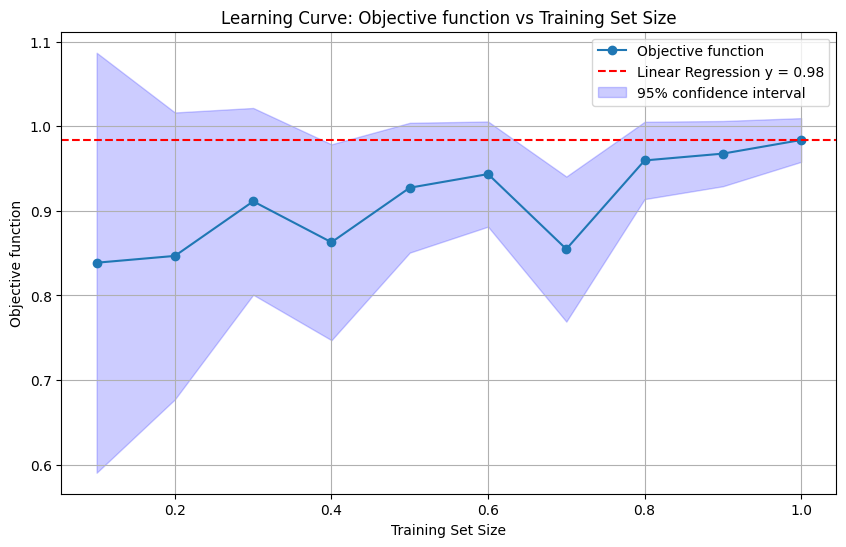

In [32]:
plot_curve_for_obj_fun(LinearClassifier(), X_train, y_train, X_test, y_test)

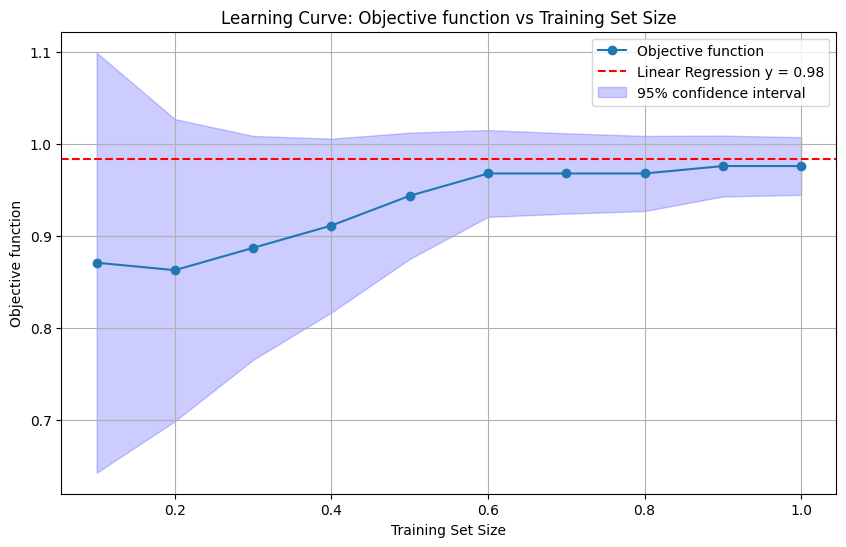

In [33]:
plot_curve_for_obj_fun(SupportVectorMachine(), X_train, y_train, X_test, y_test)